In [83]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin


class SimpleAutoBucketer(BaseEstimator, TransformerMixin):
    """
    A very simple AutoBucketer that creates KMeans clusters for features.
    Handles all data types by using KMeans on encoded values.
    
    Parameters:
    -----------
    n_buckets : int, default=5
        Number of buckets to create for each feature
    random_state : int, default=42
        Random seed for reproducibility
    """
    
    def __init__(self, n_buckets=5, random_state=42):
        self.n_buckets = n_buckets
        self.random_state = random_state
        self.encoders = {}
        self.models = {}
        self.feature_names = None
    
    def fit(self, X, y=None):
        """Fit the bucketing model on the data"""
        # Store feature names
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Process each feature
        for j, col_name in enumerate(self.feature_names):
            # Extract the feature values
            if hasattr(X, 'iloc'):
                values = X.iloc[:, j].values
            else:
                values = X[:, j]
            
            # Check if the feature is categorical
            try:
                # Try to convert to float
                numeric_values = values.astype(float)
                # If successful, use these values
                encoded_values = numeric_values.reshape(-1, 1)
                self.encoders[col_name] = None  # No encoder needed
            except (ValueError, TypeError):
                # For categorical features, use label encoding
                # Convert all values to strings first for consistency
                str_values = np.array([str(v) for v in values])
                # Get unique values and their indices
                unique_values, encoded_values = np.unique(str_values, return_inverse=True)
                # Store the encoder mapping
                self.encoders[col_name] = dict(zip(unique_values, range(len(unique_values))))
                # Reshape for KMeans
                encoded_values = encoded_values.reshape(-1, 1)
            
            lst =[]
            # Fit KMeans on the encoded values
            for nb in range(2, self.n_buckets):
                n_buckets = min(nb, len(np.unique(encoded_values)))
                if n_buckets < 2:
                    # If only one unique value, no need for bucketing
                    self.models[col_name] = None
                else:
                    # Fit KMeans
                    kmeans = KMeans(
                        n_clusters=n_buckets,
                        random_state=self.random_state,
                        n_init=10
                    )
                    kmeans.fit(encoded_values)
                    lst.append(kmeans.score(encoded_values, y))
                    
                arr = np.array(lst)
                nb = list(range(2, self.n_buckets))[np.argmax(arr)]
                
                n_buckets = min(nb, len(np.unique(encoded_values)))
                if n_buckets < 2:
                    # If only one unique value, no need for bucketing
                    self.models[col_name] = None
                else:
                    # Fit KMeans
                    kmeans = KMeans(
                        n_clusters=n_buckets,
                        random_state=self.random_state,
                        # n_init=10
                    )
                    kmeans.fit(encoded_values)
                self.models[col_name] = kmeans
        
        return self
    
    def transform(self, X):
        """Transform the data into bucket assignments"""
        # Create output array
        bucket_array = np.zeros((X.shape[0], len(self.feature_names)))
        
        # Process each feature
        for j, col_name in enumerate(self.feature_names):
            # Extract the feature values
            if hasattr(X, 'iloc'):
                values = X.iloc[:, j].values
            else:
                values = X[:, j]
            
            # Get the encoder and model
            encoder = self.encoders[col_name]
            model = self.models[col_name]
            
            if model is None:
                # If no model, just use zeros
                bucket_array[:, j] = 0
                continue
            
            # Encode the values
            if encoder is None:
                # For numeric features
                try:
                    encoded_values = values.astype(float).reshape(-1, 1)
                except (ValueError, TypeError):
                    # Fall back to zeros if conversion fails
                    bucket_array[:, j] = 0
                    continue
            else:
                # For categorical features
                str_values = np.array([str(v) for v in values])
                # Use the encoder mapping, setting -1 for unknown values
                encoded_values = np.array([encoder.get(v, -1) for v in str_values]).reshape(-1, 1)
                # Replace -1 with a valid value to avoid errors
                if -1 in encoded_values:
                    encoded_values[encoded_values == -1] = 0
            
            # Predict bucket assignments
            try:
                bucket_array[:, j] = model.predict(encoded_values)
            except:
                # If prediction fails, use zeros
                bucket_array[:, j] = 0
        
        return bucket_array
    
    def fit_transform(self, X, y=None):
        """Fit the model and transform the data in one step"""
        self.fit(X, y)
        return self.transform(X)

Loading dataset...
Using 'salary_in_usd' as target column
Training data: (3004, 9), Test data: (751, 9)
Applying auto-bucketing...

Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Making predictions...
Calculating performance metrics...

Model Performance:
R² Score: 0.3925
RMSE: 48971.62
Average 80% Prediction Interval Width: 118740.34
Creating visualizations...

Quantile regression completed successfully!


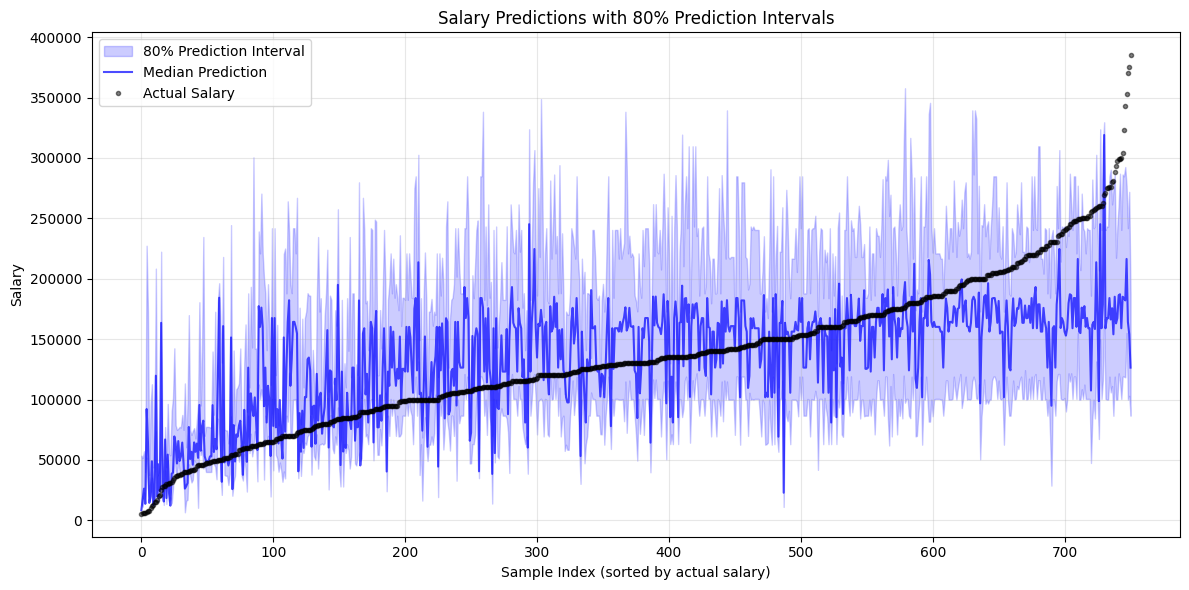

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Import the SimpleAutoBucketer
# from simple_bucketer import SimpleAutoBucketer

# Load the dataset
print("Loading dataset...")
path = "data\\ds_salaries.csv"
df = pd.read_csv(path)
df.drop(columns='salary', inplace=True)

# Find the salary column
if 'salary_in_usd' in df.columns:
    target_col = 'salary_in_usd'
elif 'salary' in df.columns:
    target_col = 'salary'
else:
    salary_cols = [col for col in df.columns if 'salary' in col.lower()]
    target_col = salary_cols[0] if salary_cols else None

print(f"Using '{target_col}' as target column")

# Create X (features) and y (target)
X = df.drop(columns=[target_col])
y = df[target_col]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")

# Create the SimpleAutoBucketer
print("Applying auto-bucketing...")
bucketer = SimpleAutoBucketer(n_buckets=40, random_state=42)
X_train_bucketed = bucketer.fit_transform(X_train)
X_test_bucketed = bucketer.transform(X_test)

# Calculate sample weights (inversely proportional to frequency)
def calculate_weights(y):
    counts = pd.Series(y).value_counts().sort_index()
    weight_map = {val: 1.0/count for val, count in counts.items()}
    return np.array([weight_map.get(val, 1.0) for val in y])

weights_train = calculate_weights(y_train)

# Train models for different quantiles
print("\nTraining quantile regression models...")
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

for q in quantiles:
    print(f"Training model for {q} quantile...")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=q,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    
    # Train the model
    model.fit(
        X_train_bucketed,
        y_train,
        sample_weight=weights_train
    )
    
    quantile_models[q] = model

# Make predictions for each quantile
print("Making predictions...")
predictions = {}
for q, model in quantile_models.items():
    predictions[q] = model.predict(X_test_bucketed)

# Calculate metrics for median (0.5 quantile) predictions
print("Calculating performance metrics...")
r2 = r2_score(y_test, predictions[0.5])
rmse = np.sqrt(mean_squared_error(y_test, predictions[0.5]))

print("\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Calculate prediction interval width
interval_width = predictions[0.9] - predictions[0.1]
avg_width = np.mean(interval_width)
print(f"Average 80% Prediction Interval Width: {avg_width:.2f}")

# Format currency for plotting
def currency_formatter(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

# Visualize predictions with prediction intervals
print("Creating visualizations...")
plt.figure(figsize=(12, 6))

# Sort test data by actual values for better visualization
sort_idx = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sort_idx]
low_sorted = predictions[0.1][sort_idx]
med_sorted = predictions[0.5][sort_idx]
high_sorted = predictions[0.9][sort_idx]

# Create index range
idx_range = np.arange(len(y_test_sorted))

# Plot predictions and intervals
plt.fill_between(idx_range, low_sorted, high_sorted, 
                alpha=0.2, color='blue', label='80% Prediction Interval')
plt.plot(idx_range, med_sorted, 'b-', alpha=0.7, label='Median Prediction')
plt.plot(idx_range, y_test_sorted, 'ko', markersize=3, alpha=0.5, label='Actual Salary')

plt.title('Salary Predictions with 80% Prediction Intervals')
plt.xlabel('Sample Index (sorted by actual salary)')
plt.ylabel('Salary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

print("\nQuantile regression completed successfully!")

In [27]:
path = "data\\ds_salaries.csv"
df = pd.read_csv(path)

In [29]:
df['salary']

0         80000
1         30000
2         25500
3        175000
4        120000
         ...   
3750     412000
3751     151000
3752     105000
3753     100000
3754    7000000
Name: salary, Length: 3755, dtype: int64

In [30]:
df.salary_in_usd

0        85847
1        30000
2        25500
3       175000
4       120000
         ...  
3750    412000
3751    151000
3752    105000
3753    100000
3754     94665
Name: salary_in_usd, Length: 3755, dtype: int64